# What drives the price of a car?

![](./images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

#### Problem Statement
What features of a used car makes it more or less expensive?

#### Goal
Identify what features contribute to the price. (Brand, Mileage, Year, Manual/Automatic Drive) Would a BMW always be more than a GMC? Do low mileage cars always contribute to a higher price?

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [497]:
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()



In [498]:
car_sales = pd.read_csv('data/vehicles.csv')
# Get information on what columns we have to work with
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [499]:
# Describe the data
print(car_sales.describe())

                 id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.804333e+04
std    4.473170e+06  1.218228e+07       9.452120  2.138815e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.308143e+09  5.900000e+03    2008.000000  3.770400e+04
50%    7.312621e+09  1.395000e+04    2013.000000  8.554800e+04
75%    7.315254e+09  2.648575e+04    2017.000000  1.335425e+05
max    7.317101e+09  3.736929e+09    2022.000000  1.000000e+07


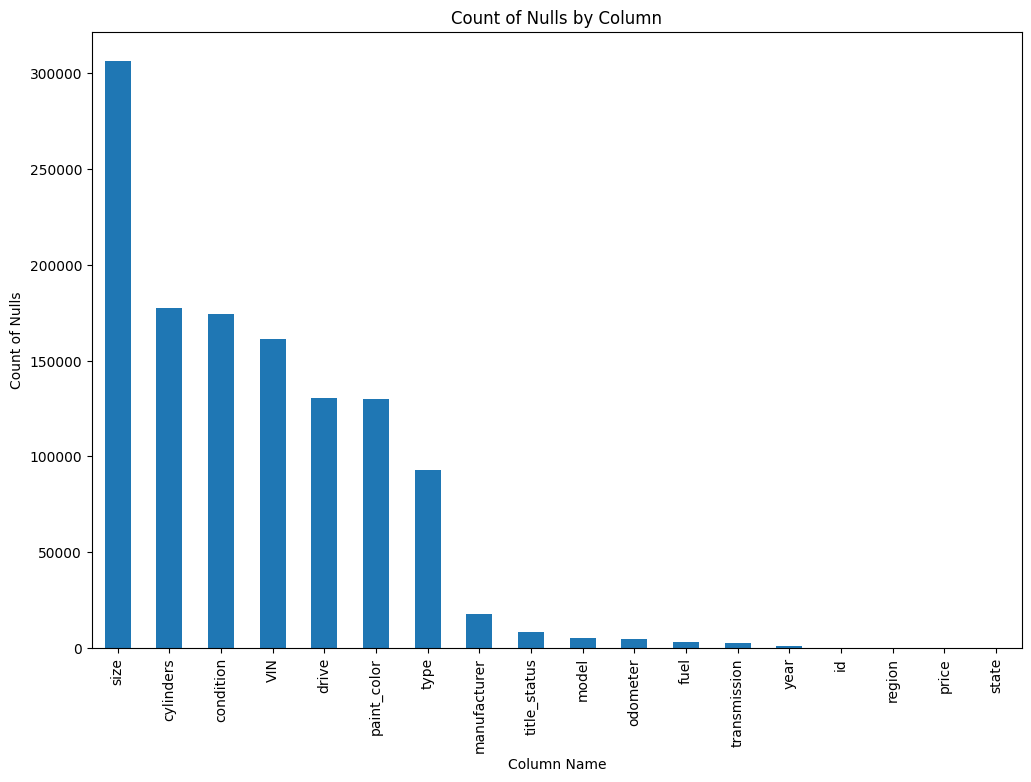

<Figure size 640x480 with 0 Axes>

In [500]:
# Check for columns with missing values
null_counts = car_sales.isnull().sum().sort_values(ascending=False)

# Create a bar chart with the count of nulls by column name
plt.figure(figsize=(12, 8))
null_counts.plot(kind='bar')
plt.title('Count of Nulls by Column')
plt.xlabel('Column Name')
plt.ylabel('Count of Nulls')
plt.show()
plt.savefig('images/count_of_nulls_by_column.png')

In [501]:
# Loop through columns to see unique counts and NaN counts
for column in car_sales.columns:
    if column not in ['id', 'region', 'price', 'state']:
        print(f'Column: {column}')
        print(f'Unique values: {car_sales[column].unique().size}')
        print(f'Number of NaN: {car_sales[column].isna().sum()}')


Column: year
Unique values: 115
Number of NaN: 1205
Column: manufacturer
Unique values: 43
Number of NaN: 17646
Column: model
Unique values: 29650
Number of NaN: 5277
Column: condition
Unique values: 7
Number of NaN: 174104
Column: cylinders
Unique values: 9
Number of NaN: 177678
Column: fuel
Unique values: 6
Number of NaN: 3013
Column: odometer
Unique values: 104871
Number of NaN: 4400
Column: title_status
Unique values: 7
Number of NaN: 8242
Column: transmission
Unique values: 4
Number of NaN: 2556
Column: VIN
Unique values: 118247
Number of NaN: 161042
Column: drive
Unique values: 4
Number of NaN: 130567
Column: size
Unique values: 5
Number of NaN: 306361
Column: type
Unique values: 14
Number of NaN: 92858
Column: paint_color
Unique values: 13
Number of NaN: 130203


#### Check initial state of data for correlation

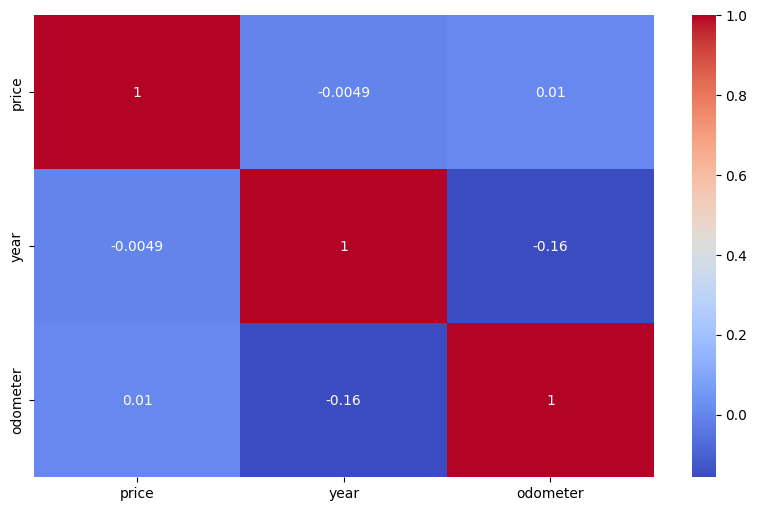

<Figure size 640x480 with 0 Axes>

In [502]:
# Do an initial correlation matrix on numeric columns
numeric_car_sales = car_sales.select_dtypes(include=['number'])
# Id is not a useful column for correlation
numeric_car_sales.drop(columns=['id'], inplace=True) 

plt.figure(figsize=(10,6))
sns.heatmap(numeric_car_sales.corr(), annot=True, cmap='coolwarm')
plt.show()
plt.savefig('images/initial_number_corr.png')

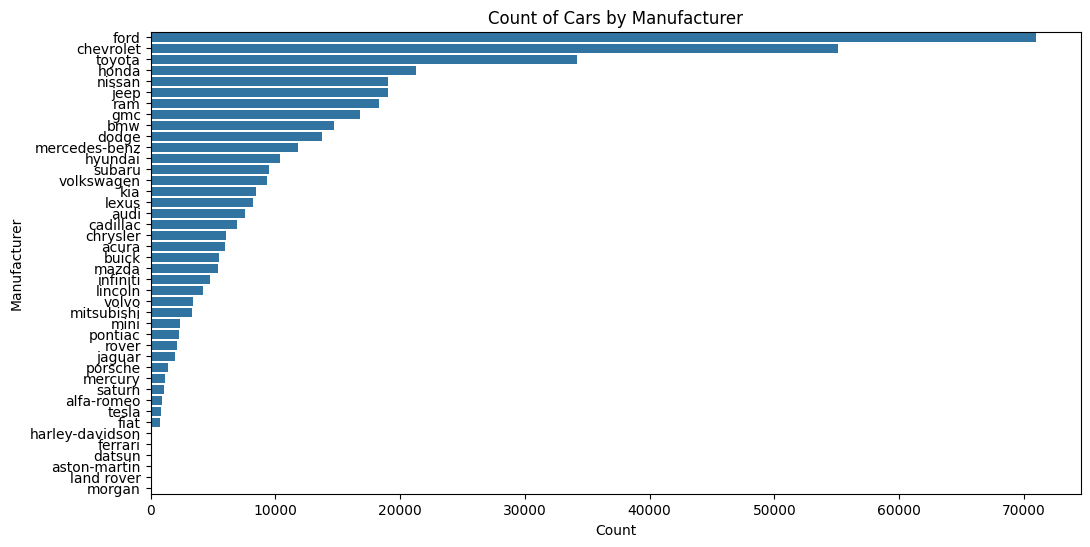

<Figure size 640x480 with 0 Axes>

In [503]:
plt.figure(figsize=(12, 6))
sns.countplot(y='manufacturer', data=car_sales, order=car_sales['manufacturer'].value_counts().index)
plt.title('Count of Cars by Manufacturer')
plt.xlabel('Count')
plt.ylabel('Manufacturer')
plt.show()
plt.savefig('images/count_by_manufacturer.png')

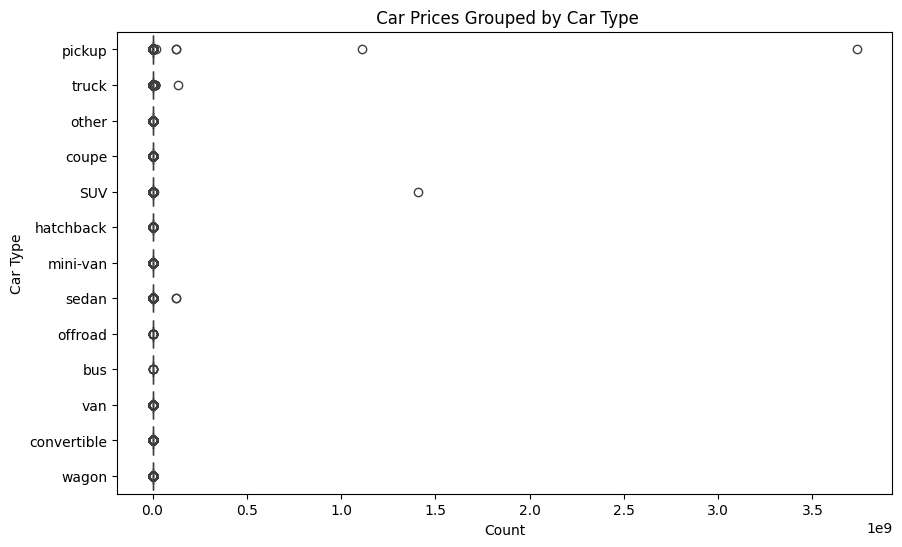

<Figure size 640x480 with 0 Axes>

In [504]:
# Plot the count of cars by type
plt.figure(figsize=(10, 6))
sns.boxplot(data=car_sales, x='price', y='type', orient='h')
plt.title(' Car Prices Grouped by Car Type')
plt.xlabel('Count')
plt.ylabel('Car Type')
plt.show()
plt.savefig('images/car_prices_type.png')

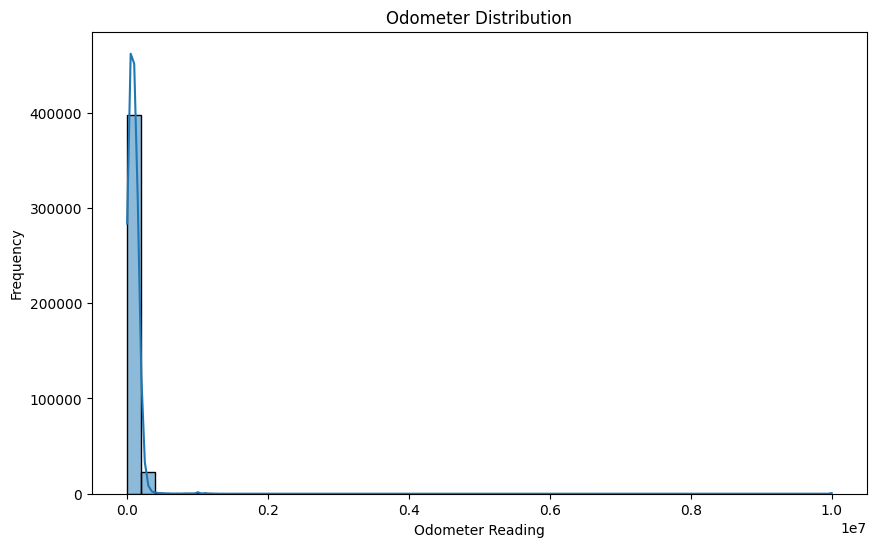

<Figure size 640x480 with 0 Axes>

In [505]:
plt.figure(figsize=(10, 6))
sns.histplot(car_sales['odometer'], bins=50, kde=True)
plt.title('Odometer Distribution')
plt.xlabel('Odometer Reading')
plt.ylabel('Frequency')
plt.show()
plt.savefig('images/odometer_distribution.png')

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

#### Remove irrelavant data

In [506]:
car_sales.drop(columns=['id'], inplace=True)  # Drop the id column
car_sales.drop_duplicates(inplace=True)  # Remove duplicates

In [507]:
# No point in keeping records that don't have a price
print(f"Number of records with price equal to zero: {car_sales[car_sales['price'] == 0].shape[0]}")
car_sales = car_sales[car_sales['price'] != 0]

# Clean up outliers in price
car_sales = car_sales[car_sales['price'] < 100000]

Number of records with price equal to zero: 25764


<Figure size 1400x800 with 0 Axes>

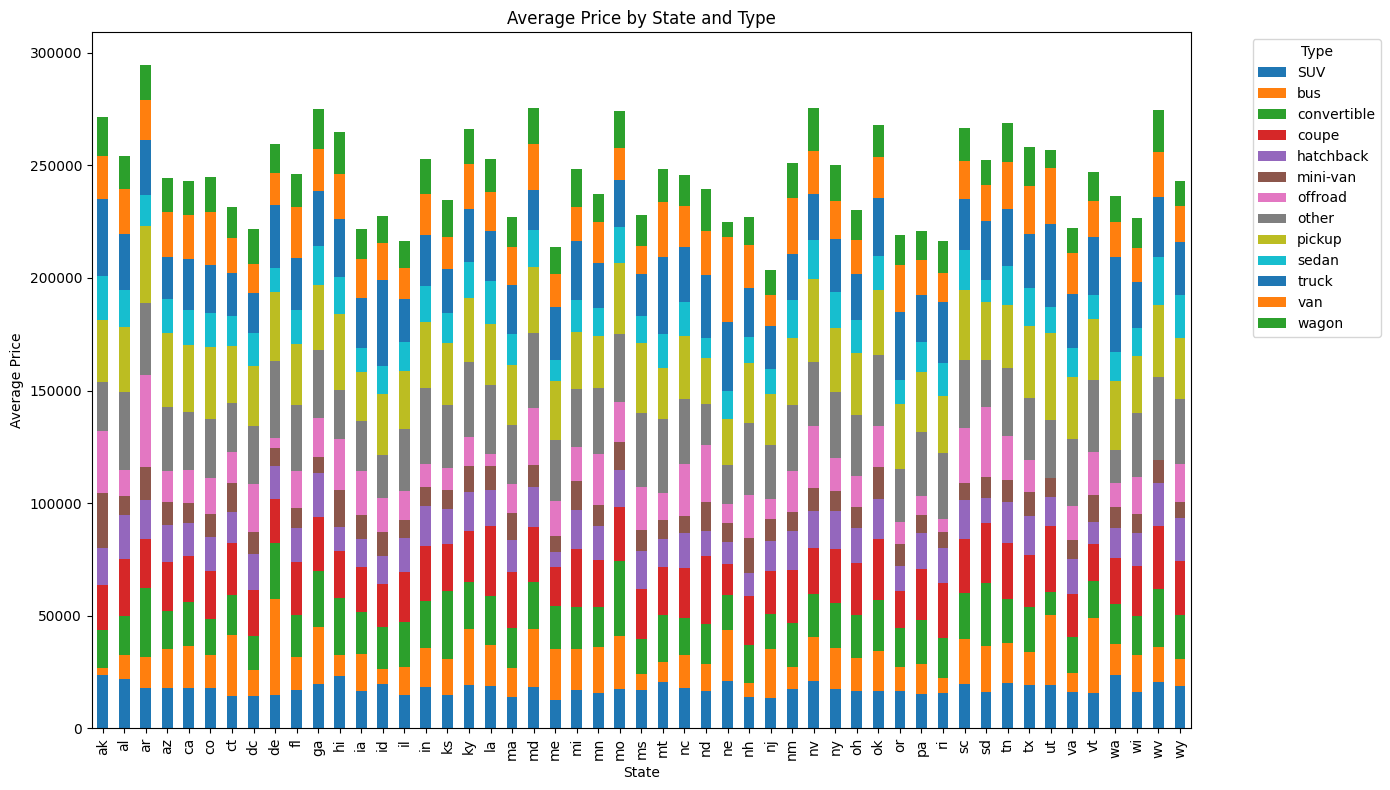

<Figure size 640x480 with 0 Axes>

In [511]:
# Group by state and manufacturer to calculate the average price
avg_price_by_state_manufacturer = car_sales.groupby(['state', 'type'])['price'].mean().unstack()

# Plot the stacked bar chart
plt.figure(figsize=(14, 8))
avg_price_by_state_manufacturer.plot(kind='bar', stacked=True, figsize=(14, 8))
plt.title('Average Price by State and Type')
plt.xlabel('State')
plt.ylabel('Average Price')
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
plt.savefig('images/avg_price_by_state_type.png')

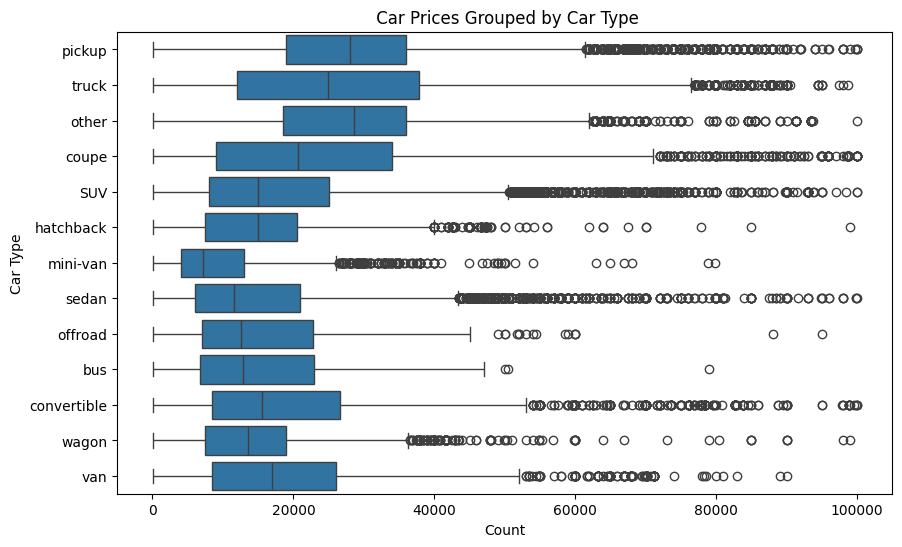

<Figure size 640x480 with 0 Axes>

In [464]:
# Plot the count of cars by type
plt.figure(figsize=(10, 6))
sns.boxplot(data=car_sales, x='price', y='type', orient='h')
plt.title(' Car Prices Grouped by Car Type')
plt.xlabel('Count')
plt.ylabel('Car Type')
plt.show()
plt.savefig('images/car_prices_type_no_zeros.png')

#### Remove unneeded columns

In [465]:
# Drop unnecessary columns with low data quality
# Region is redundant by state
car_sales.drop(columns=['size', 'VIN', 'region', 'cylinders', 'condition'], inplace=True)

#### Clean up type of car

In [466]:
# See the list of models with a type missing
# Add a type 'SUV' for models with a value of 'cherokee', 'rav4'
car_sales.loc[car_sales['model'] == 'cherokee', 'type'] = 'SUV'
car_sales.loc[car_sales['model'] == 'rav4', 'type'] = 'SUV'

# Add a type 'wagon' for models with a value of 'taurus wagon lx'
car_sales.loc[car_sales['model'] == 'taurus wagon lx', 'type'] = 'wagon'

# Add a type 'sedan' for models with a value of 'camry', 'camry xle', 'grand cherokee', 'grand prix', 'corolla'
car_sales.loc[car_sales['model'] == 'focus', 'type'] = 'sedan'

# Add a mini-van type for models with a value of 'windstar'
car_sales.loc[car_sales['model'] == 'windstar', 'type'] = 'mini-van'

# Add a type of 'pickup' for models with a value of 'F-350' and '1500 z71'
car_sales.loc[car_sales['model'] == 'F-350', 'type'] = 'pickup'
car_sales.loc[car_sales['model'] == '1500 z71', 'type'] = 'pickup'
car_sales.loc[car_sales['model'] == '2500 ls', 'type'] = 'pickup'
car_sales.loc[car_sales['model'] == 'f250 crew cab diesel', 'type'] = 'pickup'
car_sales.loc[car_sales['model'] == 'ranger rmt', 'type'] = 'pickup'
car_sales.loc[car_sales['model'] == 'apache 10', 'type'] = 'pickup'

#### Take care of some missing manufacturers

In [467]:
# Fill in the missing manufacturer values with based on the model of the car
# Update the manufacturer to chevrolet where the model is '96 Suburban'
car_sales.loc[car_sales['model'] == '96 Suburban', 'manufacturer'] = 'chevrolet'

#### Fill empties with "Unknown" or Median Values

In [468]:
# Clean up the Year and Odometer by using the median values for the missing values
car_sales['year'] = car_sales['year'].fillna(car_sales['year'].median())
car_sales['odometer'] = car_sales['odometer'].fillna(car_sales['odometer'].median())

# Fill categorical missing values with "Unknown"
categorical_cols = ['manufacturer', 'model', 'fuel', 'title_status', 'transmission', 'type', 'state', 'drive', 'paint_color']
for col in categorical_cols:
    car_sales[col] = car_sales[col].fillna("Unknown")

In [469]:
car_sales.describe()

,price,year,odometer
count,344296.000000,344296.000000,3.442960e+05
mean,18937.928306,2010.869255,9.777791e+04
std,14506.637565,9.927053,2.033691e+05
min,1.000000,1900.000000,0.000000e+00
25%,7300.000000,2008.000000,3.620300e+04
50%,15777.000000,2013.000000,8.500000e+04
75%,27990.000000,2017.000000,1.350000e+05
max,99999.000000,2022.000000,1.000000e+07


In [470]:
# Calculate the IQR for odometer readings
Q1 = car_sales['odometer'].quantile(0.25)
Q3 = car_sales['odometer'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for filtering
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the dataset to remove outliers
car_sales = car_sales[(car_sales['odometer'] >= lower_bound) & (car_sales['odometer'] <= upper_bound)]

# Display the updated dataset information
car_sales.head()

,price,year,manufacturer,model,fuel,odometer,title_status,transmission,drive,type,paint_color,state
0,6000,2013.0,Unknown,Unknown,Unknown,85000.0,Unknown,Unknown,Unknown,Unknown,Unknown,az
1,11900,2013.0,Unknown,Unknown,Unknown,85000.0,Unknown,Unknown,Unknown,Unknown,Unknown,ar
2,21000,2013.0,Unknown,Unknown,Unknown,85000.0,Unknown,Unknown,Unknown,Unknown,Unknown,fl
3,1500,2013.0,Unknown,Unknown,Unknown,85000.0,Unknown,Unknown,Unknown,Unknown,Unknown,ma
4,4900,2013.0,Unknown,Unknown,Unknown,85000.0,Unknown,Unknown,Unknown,Unknown,Unknown,nc


### Prep columns for numeric values that we'll keep

In [471]:
sales_encoded = car_sales.copy()

# Remove any records of the categorical columns that are not in the top 20
for col in ['model', 'manufacturer', 'year', 'state']:
    top_20 = sales_encoded[col].value_counts().head(20).index
    sales_encoded = sales_encoded[car_sales[col].isin(top_20)]

# One-Hot Encode only low-cardinality categorical features
sales_encoded = pd.get_dummies(sales_encoded, drop_first=True)

/var/folders/j0/1kwkdfld15s_4wkkywz5j31h0000gn/T/ipykernel_22713/3944685049.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales_encoded = sales_encoded[car_sales[col].isin(top_20)]
/var/folders/j0/1kwkdfld15s_4wkkywz5j31h0000gn/T/ipykernel_22713/3944685049.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales_encoded = sales_encoded[car_sales[col].isin(top_20)]
/var/folders/j0/1kwkdfld15s_4wkkywz5j31h0000gn/T/ipykernel_22713/3944685049.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sales_encoded = sales_encoded[car_sales[col].isin(top_20)]


In [472]:
# Add age column
sales_encoded['car_age'] = 2024 - sales_encoded['year']

In [473]:
# Check the status of the dataset
sales_encoded.head()

,price,year,odometer,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,manufacturer_chrysler,manufacturer_dodge,manufacturer_ford,...,state_ny,state_oh,state_or,state_pa,state_tn,state_tx,state_va,state_wa,state_wi,car_age
2,21000,2013.0,85000.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,11.0
3,1500,2013.0,85000.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,11.0
4,4900,2013.0,85000.0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,11.0
5,1600,2013.0,85000.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,11.0
6,1000,2013.0,85000.0,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,11.0


In [474]:
# Compute the 10th and 90th percentile
lower_bound = sales_encoded['price'].quantile(0.10)  # 10th percentile
upper_bound = sales_encoded['price'].quantile(0.90)  # 90th percentile

# Filter data within the range
sales_encoded = sales_encoded[(sales_encoded['price'] >= lower_bound) & (sales_encoded['price'] <= upper_bound)]


In [475]:
correlation_matrix = sales_encoded.corr()
print(correlation_matrix['price'].sort_values(ascending=False))

low_cardinality_cols = correlation_matrix[(correlation_matrix['price'] < 0.05) & (correlation_matrix['price'] > -0.05)].index
print(low_cardinality_cols)
# Drop correlations that have a correlation of less than 0.1 and greater than -0.1
sales_encoded.drop(columns=low_cardinality_cols, inplace=True)

price                 1.000000
year                  0.567512
type_pickup           0.232412
type_truck            0.192648
manufacturer_ram      0.190836
                        ...   
manufacturer_honda   -0.213121
drive_fwd            -0.257484
type_sedan           -0.269926
odometer             -0.469059
car_age              -0.567512
Name: price, Length: 103, dtype: float64
Index(['manufacturer_bmw', 'manufacturer_buick', 'manufacturer_cadillac',
       'manufacturer_chrysler', 'manufacturer_dodge', 'manufacturer_gmc',
       'manufacturer_lexus', 'manufacturer_lincoln',
       'manufacturer_mercedes-benz', 'manufacturer_rover',
       'manufacturer_volkswagen', 'manufacturer_volvo', 'model_Unknown',
       'model_explorer', 'model_grand cherokee', 'model_mustang',
       'model_silverado', 'fuel_electric', 'fuel_hybrid', 'title_status_lien',
       'title_status_missing', 'title_status_parts only',
       'title_status_rebuilt', 'transmission_automatic', 'transmission_manual',
  

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [481]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, cross_val_score

#### Create test and train splits

In [482]:
#generate train/test data for car sales
sales_X = sales_encoded.drop(['price'], axis = 1)
sales_y = sales_encoded['price']
sales_X_train, sales_X_test, sales_y_train, sales_y_test = train_test_split(sales_X, sales_y, 
                                                                       test_size = 0.3,
                                                                       random_state = 42)

In [483]:
# Define pipeline with preprocessing (PolynomialFeatures + StandardScaler) and model
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Create polynomial features
    ('scaler', StandardScaler()),  # Standardize features
    ('model', LinearRegression())  # Linear Regression model
])

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation using the pipeline
mse_scores = -cross_val_score(pipeline, sales_X, sales_y, cv=kf, scoring='neg_mean_squared_error')

# Print results
print("MSE for each fold:", mse_scores)
print("Mean MSE:", np.mean(mse_scores))

MSE for each fold: [12416698.66683194 12571841.88585853 11701569.10710359 12268654.4277467
 13554951.5863396 ]
Mean MSE: 12502743.13477607


#### Linear Regression Pipeline

In [484]:
lin_reg = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Create polynomial features
    ('scaler', StandardScaler()),
    ('reg', LinearRegression())
])

lin_reg.fit(sales_X_train, sales_y_train)
y_pred = lin_reg.predict(sales_X_test)

# Evaluate Model
mse = mean_squared_error(sales_y_test, y_pred)
r2 = r2_score(sales_y_test, y_pred)

print(f"🔹 Linear Regression - MSE: {mse:.2f}, R²: {r2:.4f}")


🔹 Linear Regression - MSE: 12788792.79, R²: 0.8397


#### Try Ridge and Lasso

In [485]:
ridge = Ridge(alpha=2)
ridge.fit(sales_X_train, sales_y_train)
ridge_pred = ridge.predict(sales_X_test)

lasso = Lasso(alpha=.1)
lasso.fit(sales_X_train, sales_y_train)
lasso_pred = lasso.predict(sales_X_test)


mse_ridge = mean_squared_error(sales_y_test, ridge_pred)
r2_ridge = r2_score(sales_y_test, ridge_pred)
print(f"🔹 Ridge Regression - MSE: {mse_ridge:.2f}, R²: {r2_ridge:.4f}")

mse_lasso = mean_squared_error(sales_y_test, lasso_pred)
r2_lasso = r2_score(sales_y_test, lasso_pred)
print(f"🔹 Lasso Regression - MSE: {mse_lasso:.2f}, R²: {r2_lasso:.4f}")

🔹 Ridge Regression - MSE: 16607845.17, R²: 0.7918
🔹 Lasso Regression - MSE: 16607428.74, R²: 0.7918


/Users/ethanflory/Documents/Repositiories/BerkeleyClass/venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.433e+11, tolerance: 1.386e+08
  model = cd_fast.enet_coordinate_descent(


#### Try smaller datasets based on corr

In [488]:
sales_X = sales_encoded[['odometer', 'year', 'car_age'] + [col for col in sales_encoded.columns if col.startswith('type_')]]
sales_y = sales_encoded['price']
sales_X_train, sales_X_test, sales_y_train, sales_y_test = train_test_split(sales_X, sales_y, 
                                                                       test_size = 0.3,
                                                                       random_state = 42)

In [489]:
# Redo the k-fold linear regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Create polynomial features
    ('scaler', StandardScaler()),  # Standardize features
    ('model', LinearRegression())  # Linear Regression model
])

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform Cross-Validation using the pipeline
mse_scores = -cross_val_score(pipeline, sales_X, sales_y, cv=kf, scoring='neg_mean_squared_error')

# Print results
print("MSE for each fold:", mse_scores)
print("Mean MSE:", np.mean(mse_scores))

MSE for each fold: [32675287.13970475 31681055.87603927 31719083.61559515 33908329.2973636
 33132303.96076081]
Mean MSE: 32623211.977892715


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.